In [35]:
from __future__ import absolute_import
from __future__ import print_function
import matplotlib.pyplot as plt

import autograd.numpy as np
import autograd.numpy.random as npr
import autograd.scipy.stats.norm as norm
from scipy.stats import norm as normsp

from autograd import grad, elementwise_grad
from autograd.core import primitive

from autograd.util import flatten


from autograd.optimizers import adam

In [36]:
%matplotlib inline

In [37]:
def get_params(N_rec=2):   
    # it's a recursive function, with 3 parameters per recursion
    mu_params = npr.uniform(0,1,N_rec)
    sig_params = npr.uniform(0.01,1,N_rec)
    I = norm.cdf(1,mu_params,sig_params)-norm.cdf(0,mu_params,sig_params)    
    f_params=npr.uniform(1./(1-1/(np.sqrt(2*np.pi)*sig_params*I)),1,N_rec)
    rec_params =np.ravel(np.vstack((f_params.reshape(1,N_rec),mu_params.reshape(1,N_rec),sig_params.reshape(1,N_rec))).T)
    return rec_params

In [38]:
def finv(x,params):
    """this is a random bijection I made up from [0,1]->[0,1] that is composed recursively"""
    
    [f,mu,sig] = params[0:3]
    #print(params[0:3])
    I = norm.cdf(1,mu,sig)-norm.cdf(0,mu,sig)
    z = (1-f)*x + f*(norm.cdf(x,mu,sig)-norm.cdf(0,mu,sig))/I
    if params.size ==3:
        return z
    else:
        return finv(z,params[3:])
    
grad_finv = elementwise_grad(finv)

In [39]:
def f(v, params):
    #not sure what f is, but don't need it really
    return Null

In [40]:
def sample_model(params,N=100):
    v=npr.uniform(0,1,N)
    return finv(v,params)

In [41]:
def get_model_density_pairs_for_scatter(params,n_samp=100):
    v=npr.uniform(0,1,n_samp)
    z=finv(v,params)
    density=1./grad_finv(v,params)
    return z,density

In [42]:
def folding_density(x,z):
    return norm.pdf(x,z,.2*(.51-np.abs(z-.5)))

In [43]:
def sample_folding(z):
    #add cropping protection. Breaks density a little, hopefully a small effect
    return np.minimum(1,np.maximum(0,npr.normal(z,.2*(.51-np.abs(z-.5)))))

In [44]:
def sample_folded(params, N=100):
    return sample_folding(sample_model(params,N))

In [45]:
def folded_density_z(x,params,M=100):
    temp_z = sample_model(params,M)
    return np.sum(np.reshape(folding_density(np.repeat(x,M),np.tile(temp_z,x.size)),(x.size,M)),axis=1)/M

In [46]:
def folded_density_maker(M=100):
    v = npr.uniform(0,1,M)
    
    def eval(x,p, update=False):
        if update:
            #print("current samples {}".format(samples))
            nonlocal v 
            v = npr.uniform(0,1,M)
            #print("new samples {}".format(samples))
        temp_z = finv(v,p)
        #print(temp_z)
        #print(M,np.repeat(x,M).shape)
        #print(temp_z.shape,x.shape)
        #print(np.tile(temp_z,x.size).shape)
        return np.sum(np.reshape(folding_density(np.repeat(x,M),np.tile(temp_z,x.size)),(x.size,M)),axis=1)/M    
    return eval

folded_density = folded_density_maker(M=1000)

In [47]:
def sum_log_folded_density_from_finv(x, params):
    return -np.sum(np.log(folded_density(x,params)))

array([ 0.3 ,  0.3 ,  0.01,  0.3 ,  0.7 ,  0.01])

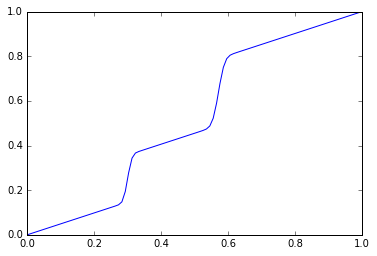

In [48]:
#some reference benchmark
true_params = np.array([ 0.4083108 ,  0.99154278,  0.69573285, -9.84400854,  0.72714937,
        0.84465603, -1.60273329,  0.08075483,  0.45562299])
true_params = np.array([0.3,  .3,  0.01,
                        0.3,  0.7, 0.01])
#true_params=get_params()
plt.plot(np.linspace(0,1,100),finv(np.linspace(0,1,100),true_params))
true_params

array([-3.5 ,  0.3 ,  0.5 , -3.5 ,  0.6 ,  0.45])

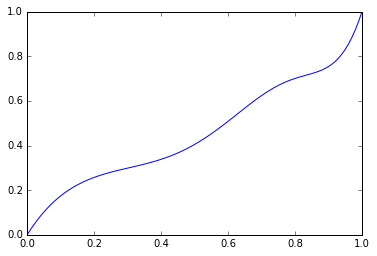

In [49]:
#some reference benchmark
true_params = np.array([-3.5,  .3,  0.5, -3.5,  0.6, 0.45])
#true_params=get_params()
plt.plot(np.linspace(0,1,100),finv(np.linspace(0,1,100),true_params))
true_params

array([-2.15419877,  0.06246513,  0.58221193,  0.62469513,  0.74609329,
        0.63039381, -0.39393009,  0.89167027,  0.40848736, -0.31238   ,
        0.67369353,  0.37367736, -0.45461462,  0.23507714,  0.1577296 ,
       -1.37687813,  0.32393999,  0.84225987])

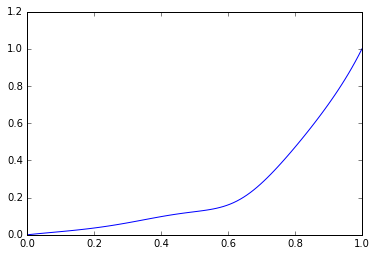

In [54]:
#get random parameters for true distribution
true_params = get_params(N_rec=6)
plt.plot(np.linspace(0,1,100),finv(np.linspace(0,1,100),true_params))
true_params

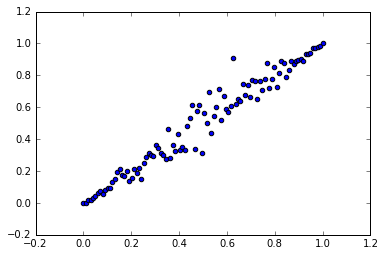

In [55]:
z_test = np.linspace(0,1,100)
x_test = sample_folding(z_test)
plt.scatter(z_test,x_test)

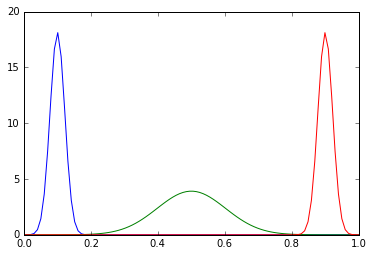

In [56]:
plt.plot(np.linspace(0,1,100),folding_density(np.linspace(0,1,100),.1+0*z_test))
plt.plot(np.linspace(0,1,100),folding_density(np.linspace(0,1,100),.5+0*z_test))
plt.plot(np.linspace(0,1,100),folding_density(np.linspace(0,1,100),.9+0*z_test))

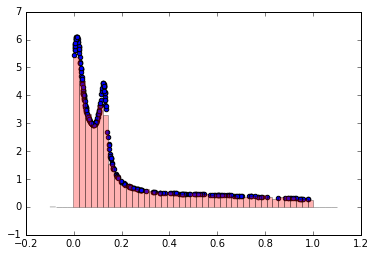

In [57]:
bins=np.linspace(-.1,1.1,50)
_ = plt.hist(sample_model(true_params,10000), bins=bins, alpha=0.3, color='red', normed=True)
z_test, pz_test = get_model_density_pairs_for_scatter(true_params,300)
plt.scatter(z_test,pz_test)

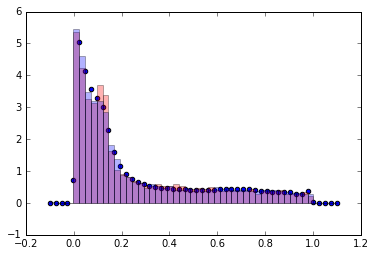

In [58]:
bins=np.linspace(-.1,1.1,50)
_ = plt.hist(sample_model(true_params,10000), bins=bins, alpha=0.3, color='red', normed=True)
_ = plt.hist(sample_folded(true_params,10000), bins=bins, alpha=0.3,color='blue', normed=True)
plt.scatter(bins, folded_density(bins,true_params))

In [59]:
sum_log_folded_density_from_finv(bins,true_params)

153.99757776407586

In [60]:
dummy_data = sample_model(true_params,1000)

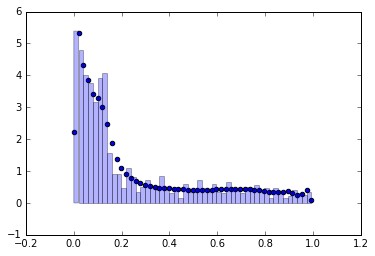

In [61]:
counts, bins, patches = plt.hist(dummy_data,50, alpha=.3,normed=True)
plt.scatter(bins, folded_density(bins,true_params))

In [70]:
def doIt():
    #true_params = np.array([.8,-1,.3,.5,.2])

    init_params = get_params(N_rec=6)
    init_params = true_params
    #init_params[0:-1:3]=0 #uniform distribution
    #init_params[0:-1:3]=0.1 #nearly uniform distribution



    data = sample_folded(true_params,10000)
    mini_batch = 3000
    
    def objective(params, t):
        npr.shuffle(data)
        if t%5==0: #force update of v->z samples in integral 
            folded_density(data[0],params,update=True)
        penalty = 1E6*np.maximum(0,(np.abs(params[0]-.5)-0.5))
        return sum_log_folded_density_from_finv(data[0:mini_batch], params)+penalty
        #return sum_log_density_from_finv(data[0:mini_batch], params)+penalty
        #return sum_log_mixtureModel(data[0:mini_batch], params)+penalty

    print(grad(objective)(init_params, 0))

    # Set up figure.
    fig = plt.figure(figsize=(12,8), facecolor='white')
    ax = fig.add_subplot(111, frameon=True)
    plt.show(block=False)

    x_test = np.linspace(0,1,100)
    px_true_test = folded_density(x_test,true_params)

    z_true_test, pz_true_test = get_model_density_pairs_for_scatter(true_params)

    def callback(params, t, g):
        print("Iteration {} log likelihood {} params {}".format(t, -objective(params, t),params))
        print("penalty is {}".format(1E6*np.maximum(0,np.abs(params[0]-.5)-0.5)))

        z_test, pz_test = get_model_density_pairs_for_scatter(params)
        
        # Plot data and functions.
        plt.cla()
        plt.title('t={}'.format(t))

        ax.scatter(z_test,pz_test,color='b')
        ax.scatter(z_true_test,pz_true_test,color='r')

        ax.plot(x_test,px_true_test,c='b')
        _ = ax.hist(data, 50, normed=True,color='r',alpha=.3)

        plt.ylim(0,7)
        plt.xlim(0,1)

        plt.draw()
        plt.pause(1.0/60.0)

    print("Optimizing network parameters...")
    optimized_params = adam(grad(objective), init_params,
                            step_size=0.003, num_iters=1000, callback=callback)
    return plt.savefig('unfolded.png')

In [71]:
%matplotlib
doIt()

Using matplotlib backend: MacOSX
[ -1.00000547e+06  -2.49937198e+02  -8.62409833e+01  -7.90071945e+00
  -4.19048922e+01   1.41356547e+01  -5.35618888e+01   9.18145080e+01
  -8.66219402e+01  -3.85899645e+00   5.51953474e+01   2.32314467e+00
   8.71576875e+01   1.71832595e+02   9.09558102e+01   1.00327652e+01
   5.48976679e+01   3.02406745e+01]
Optimizing network parameters...
Iteration 0 log likelihood -2152556.606196986 params [-2.15419877  0.06246513  0.58221193  0.62469513  0.74609329  0.63039381
 -0.39393009  0.89167027  0.40848736 -0.31238     0.67369353  0.37367736
 -0.45461462  0.23507714  0.1577296  -1.37687813  0.32393999  0.84225987]
penalty is 2154198.7735115257
Iteration 1 log likelihood -2149536.469730607 params [-2.15119877  0.05946513  0.57921193  0.62769513  0.74909329  0.62739381
 -0.39093009  0.89467027  0.40548736 -0.30938     0.67669353  0.37667736
 -0.45761462  0.23207714  0.1547296  -1.37387813  0.32093999  0.84525987]
penalty is 2151198.7735115252
Iteration 2 log 

In [72]:
%matplotlib inline

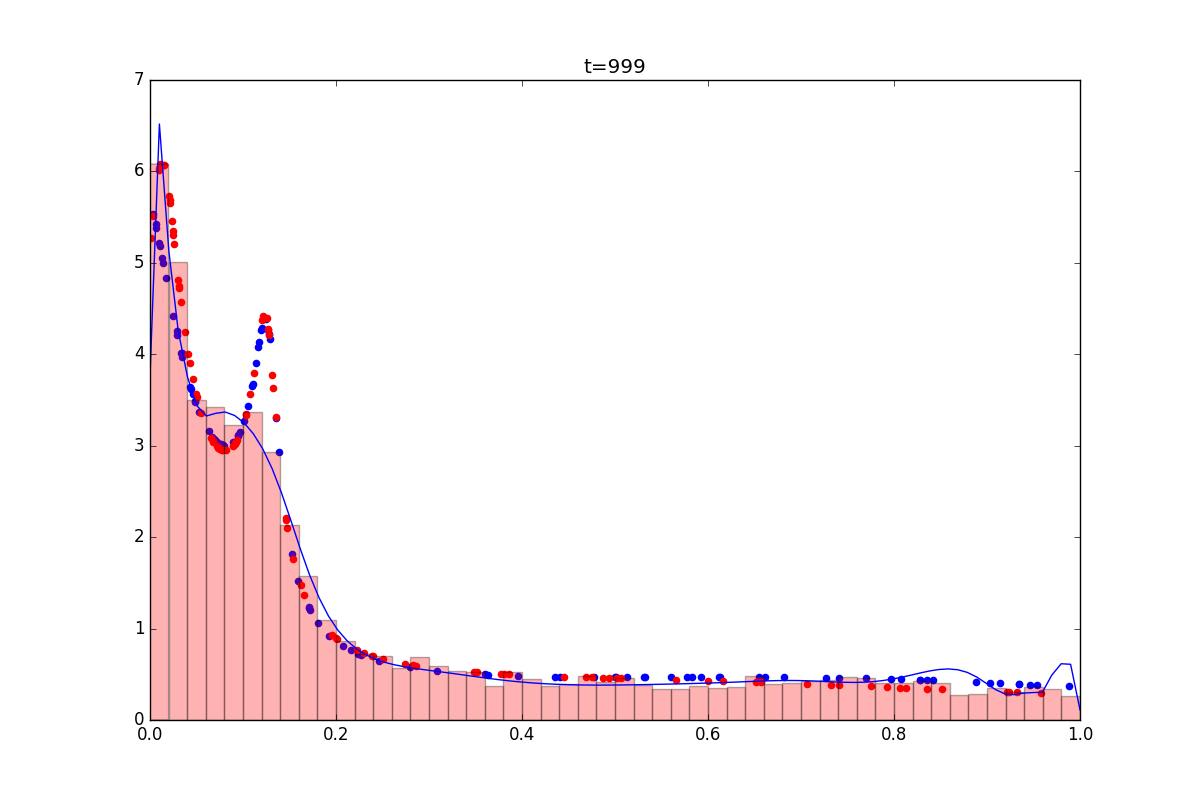

In [73]:
from IPython.display import Image
Image("unfolded.png")
#folded true density solid line, histogram observed folded data
#red dots are true unfolded distribution, blue dots are estimate of unfolded distribution